# CatBoost tutorial: Categorical features parameters

*Mastering the parameters you didn't know exist*

| ![cats](https://metro.co.uk/wp-content/uploads/2015/03/ad_162754294.jpg?quality=90&strip=all) | 
|:--:| 
| *Categorical feature example: cat's face shape* |


CatBoost is an open-sourced gradient boosting library. One of the differences between CatBoost and other gradient boosting libraries is its advanced processing of the categorical features (in fact "Cat" in the package name stands not for a 🐱 but for "CATegorical").

CatBoost deals with the categorical data quite well out-of-the-box. However, it also has a huge number of training parameters, which provide fine control over the categorical features preprocessing. In this tutorial, we are going to learn how to use these parameters for the greater good. The tutorial is split into the following sections:

1. **Introduction: categorical features in machine learning**
2. **Categorical features processing in CatBoost**
3. **Experiment: How the categorical features settings affect accuracy in predicting the prices of the old cars**.

# 1. Introduction: categorical features in machine learning
**Сategorical feature** is a feature that has a discrete set of values called *categories* that are *not comparable* by < or > to each other. In real-world datasets, we quite often deal with categorical data. The cardinality of a categorical feature, i.e. the number of different values that the feature can take varies drastically among features and datasets -- from just a few to thousands and millions of distinct values. The values of a categorical feature can be distributed almost uniformly and there might be values with a frequency different by the orders of magnitude. To be used in gradient boosting categorical features need to be transformed to some form that can be handeled by a decision tree, for example to numbers. In the next section, we are going to briefly go through the most popular in machine learning methods of transforming categorical features values into numbers.
Standard approaches to categorical features preprocessing
* **One-hot Encoding** consists in creating a binary feature for each category. The main problem of the method is that features with huge cardinalities (such as user id for example) lead to a huge number of features.
* **Label Encoding** maps each category, i.e. value that a categorical feature can take into a random number. Does it not make a terrible amount of sense? It does not work very well in practice either.
* **Hash Encoding** converts string type features into a fixed dimension vector using a hash function.
* **Frequency Encoding** consists in replacing categorical feature values with the frequency of the category in the dataset.
* **Target Encoding** replaces the values of the categorical feature with a number that is calculated from the distribution of the target values for that particular value of the categorical variable. The most straightforward approach sometimes referred to as **Greedy Target Encoding** is to use the mean value of target on the objects belonging to the category. However, this method leads to target leakage and overfitting. One possible solution to these problems is **Holdout Target Encoding** -- one part of the training dataset is used to compute the target statistics for each category, and the training is performed on the rest of the training data. It solves the target leakage problem but requires us to sacrifice part of our precious training data. For this reason, the most popular in practice solutions are **K-Fold Target Encoding** and **Leave-One-Out Target Encoding**. The idea behind K-Fold Target Encoding is very similar to K-Fold Cross Validation -- we split the training data into several folds in each fold we replace the categorical feature values with the target statistics for the category calculated on the other folds. Leave-One-Out Target Encoding is a special case of K-Fold Encoding where K is equal to the length of training data. K-Fold Encoding and Leave-One-Out Target Encoding can also lead to overfitting. Consider the following example: in a training dataset, we have a single categorical feature with a single value and 5 objects of class 0 and 6 objects of class 1. Obviously feature that has only one possible value is useless, however, if we use Leave-One-Out Target Encoding with mean function for all the objects of class 0 the feature value will be encoded into 0.6 while for all the objects of class 1 the feature encoding value will be 0.5. This will allow a decision tree classifier to choose a split at 0.55 and achieve 100% accuracy on the training set. 

# 2. Categorical features processing in CatBoost
CatBoost supports some traditional methods of categorical data preprocessing, such as One-hot Encoding and Frequency Encoding. However one of the signatures of this package is its original solution for categorical features encoding. 

The core idea behind CatBoost categorical features preprocessing is **Ordered Target Encoding**: a random permutation of the dataset is performed and then target encoding of some type (for example just computing mean of the target for objects of this category) is performed on each example *using only the objects that are placed before the current object*.

Generally transforming categorical features to numerical features in CatBoost includes the following steps:

1. **Permutation** of the training objects in random order. 
2. **Quantization** i.e. converting the target value from a floating point to an integer depending on the task type:
    * Classification - Possible values for target value are “0” (doesn't belong to the specified target class) and “1” (belongs to the specified target class).
    * Multiclassification - The target values are integer identifiers of target classes (starting from “0”).
    * Regression - Quantization is performed on the label value. **The mode and number of buckets are set in the starting parameters**. All values located inside a single bucket are assigned a label value class – an integer in the range defined by the formula: <bucket ID – 1>. 
3. **Encoding** the categorical feature values. 

CatBoost creates four permutations of the training objects and for each permutation, a separate model is trained. Three models are used for the tree structure selection and the fourth is used to compute the leaves values of the final model that we save. At each iteration one of the three models is chosen randomly; this model is used to choose the new tree structure and to calculate the leaves values for all the four models. 

Using several models for tree structure selection enhances the robustness of the categorical features encoding. If in one permutation an object is close to the beginning of the dataset and the statistics for encoding are calculated on a small number of objects in the other two permutations it may be closer to the end of the dataset and many objects will be used to compute the statistics. 

Another important point is that **CatBoost can create new categorical features combining the existing ones**. And it will actually do so unless you explicitly tell it not to :) Treatment of the original features and the created features can be controlled separately by the settings `simple_ctr` and `combinations_ctr` respectively (we will talk about them in detail). 
    
# 3. Categorical features parameters in practice: the old cars prices prediction

![cars](https://www.ratchetandwrench.com/ext/resources/car-sales.jpg?1488213871)

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold

## Dataset

For the experiments in this tutorial, we are going to use https://www.kaggle.com/lepchenkov/usedcarscatalog 

This dataset consists of the old cars descriptions and their characteristics - both numerical, such as mileage, production year, etc and categorical, such as color, manufacturer name, model name, etc.

Our goal is to solve the *regression* task, i.e. to predict the price of an old car.

In [4]:
!wget https://gist.githubusercontent.com/garkavem/2613ca62c9ace338b217eccc99fe1f6f/raw/981dae5111bb2a30e20dca888a99020d5c4f5899/gistfile1.txt -O cars.csv

--2020-05-09 17:40:21--  https://gist.githubusercontent.com/garkavem/2613ca62c9ace338b217eccc99fe1f6f/raw/981dae5111bb2a30e20dca888a99020d5c4f5899/gistfile1.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7542506 (7.2M) [text/plain]
Saving to: ‘cars.csv’

cars.csv            100%[===================>]   7.19M  --.-KB/s    in 0.1s    

2020-05-09 17:40:21 (51.3 MB/s) - ‘cars.csv’ saved [7542506/7542506]



In [2]:
df = pd.read_csv('cars.csv')

In [3]:
df

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,...,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Subaru,Outback,automatic,silver,190000,2010,gasoline,False,gasoline,2.5,...,True,True,True,False,True,False,True,True,True,16
1,Subaru,Outback,automatic,blue,290000,2002,gasoline,False,gasoline,3.0,...,True,False,False,True,True,False,False,False,True,83
2,Subaru,Forester,automatic,red,402000,2001,gasoline,False,gasoline,2.5,...,True,False,False,False,False,False,False,True,True,151
3,Subaru,Impreza,mechanical,blue,10000,1999,gasoline,False,gasoline,3.0,...,False,False,False,False,False,False,False,False,False,86
4,Subaru,Legacy,automatic,black,280000,2001,gasoline,False,gasoline,2.5,...,True,False,True,True,False,False,False,False,True,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38526,Chrysler,300,automatic,silver,290000,2000,gasoline,False,gasoline,3.5,...,True,False,False,True,True,False,False,True,True,301
38527,Chrysler,PT Cruiser,mechanical,blue,321000,2004,diesel,False,diesel,2.2,...,True,False,False,True,True,False,False,True,True,317
38528,Chrysler,300,automatic,blue,777957,2000,gasoline,False,gasoline,3.5,...,True,False,False,True,True,False,False,True,True,369
38529,Chrysler,PT Cruiser,mechanical,black,20000,2001,gasoline,False,gasoline,2.0,...,True,False,False,False,False,False,False,False,True,490


In [4]:
categorical_features_names = ['manufacturer_name', 'model_name', 'transmission', 'color', 'engine_fuel',
                              'engine_type',  'body_type',  'state', 'drivetrain','location_region']

Lets see how many unique values each categorical variable has:

In [5]:
df[categorical_features_names].nunique()

manufacturer_name      55
model_name           1118
transmission            2
color                  12
engine_fuel             6
engine_type             3
body_type              12
state                   3
drivetrain              3
location_region         6
dtype: int64

Here is the target value distribution:

4800.0

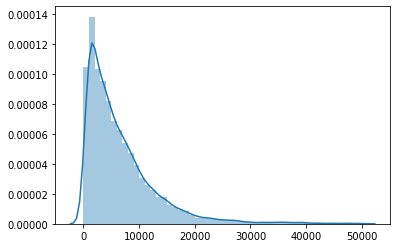

In [6]:
sns.distplot(df.price_usd.values)
np.median(df.price_usd.values)

First, we are going to roughly estimate the number of trees and the learning rate required that are sufficient for this task. 

In [0]:
!pip install catboost

     |████████████████████████████████| 64.8MB 45kB/s 


In [7]:
from catboost import CatBoost, CatBoostRegressor, Pool
df_ = df.sample(frac=1., random_state=0)
df_train = df_.iloc[: 2 * len(df) // 3]
df_test = df_.iloc[2 * len(df) // 3 :]
train_pool = Pool(df_train.drop(['price_usd'], 1), 
                  label=df_train.price_usd,
                  cat_features=categorical_features_names)
test_pool = Pool(df_test.drop(['price_usd'], 1),
                 label=df_test.price_usd,
                 cat_features=categorical_features_names)

In [13]:
model = CatBoostRegressor(custom_metric= ['R2', 'RMSE'], learning_rate=0.1, n_estimators=5000)
model.fit(train_pool, eval_set=test_pool, verbose=2000, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 5935.7603510	test: 6046.0339243	best: 6046.0339243 (0)	total: 43ms	remaining: 3m 34s
2000:	learn: 1052.8405096	test: 1684.8571308	best: 1684.8571308 (2000)	total: 21.2s	remaining: 31.8s
4000:	learn: 830.0093394	test: 1669.1267503	best: 1668.7626148 (3888)	total: 44.9s	remaining: 11.2s
4999:	learn: 753.5299104	test: 1666.7826842	best: 1666.6739968 (4463)	total: 56.2s	remaining: 0us

bestTest = 1666.673997
bestIteration = 4463

Shrink model to first 4464 iterations.


Now we are going to write a simple function that tests CatBoost performance on 3-fold cross-validation given the parameters and returns the full list of parameters for the last model. Optionally this function compares the model's metrics with the results of the model trained with the default categorical features parameters.

We will fix the number of estimators at 4500 and the learning rate at 0.1. 

In [8]:
kf = KFold(n_splits=3, shuffle=True)
DEFAULT_PARAMETERS = {'n_estimators' : 4500, 'learning_rate' : 0.1}
DEFAULT_MODEL_METRICS = {}

def score_catboost_model(catboost_parameters, update_defaults=False):
    r2_values = []
    rmse_values = []
    catboost_parameters.update(DEFAULT_PARAMETERS)
    for train_index, test_index in kf.split(df):
        train_pool = Pool(df.iloc[train_index].drop(['price_usd'], 1),
                          label=df.iloc[train_index].price_usd,
                          cat_features=categorical_features_names)
        test_pool = Pool(df.iloc[test_index].drop(['price_usd'], 1),
                        label=df.iloc[test_index].price_usd,
                        cat_features=categorical_features_names)
        model = CatBoost(catboost_parameters)
        model.fit(train_pool, verbose=False)
        
        r2_values.append(r2_score(df.iloc[test_index].price_usd.values, model.predict(test_pool)))
        rmse_values.append(mean_squared_error(df.iloc[test_index].price_usd.values,
                                              model.predict(test_pool),
                                              squared=False)) 
    if update_defaults:
        DEFAULT_MODEL_METRICS['R2'] = np.mean(r2_values)
        DEFAULT_MODEL_METRICS['RMSE'] = np.mean(rmse_values)
        print('R2 score: {:.4f}({:.4f})'.format(np.mean(r2_values), np.std(r2_values)))
        print('RMSE score: {:.0f}({:.0f})'.format(np.mean(rmse_values), np.std(rmse_values)))  

    else:
        DEFAULT_MODEL_R2 = DEFAULT_MODEL_METRICS['R2']
        DEFAULT_MODEL_RMSE = DEFAULT_MODEL_METRICS['RMSE']
        r2_change = 100 * (np.mean(r2_values) - DEFAULT_MODEL_R2) / DEFAULT_MODEL_R2
        rmse_change = 100 * (np.mean(rmse_values) - DEFAULT_MODEL_RMSE) / DEFAULT_MODEL_RMSE
        print('R2 score: {:.4f}({:.4f}) {:+.1f}% compared to default parameters'.format(
            np.mean(r2_values), np.std(r2_values), r2_change))
        print('RMSE score: {:.0f}({:.0f}) {:+.1f}% compared to default parameters'.format(
            np.mean(rmse_values), np.std(rmse_values), rmse_change))  
        
    return model.get_all_params()

# Categorical features encoding parameters in CatBoost

The amount of parameters related to categorical features processing in CatBoost is overwhelming. Here is a hopefully the full list:
* `one_hot_max_size` (int) - use one-hot encoding for all categorical features with a number of different values less than or equal to the given parameter value. No complex encoding is performed for such features. *Default for regression task is 2.*
* `model_size_reg` (float from 0 to inf) - The model size regularization coefficient. The larger the value, the smaller the model size. Refer to the Model size regularization coefficient section for details. This regularization is needed only for models with categorical features (other models are small). Models with categorical features might weight tens of gigabytes or more if categorical features have a lot of values. If the value of the regularizer differs from zero, then the usage of categorical features or feature combinations with a lot of values has a penalty, so fewer of them are used in the resulting model. *Default value is 0.5*
* `max_ctr_complexity` - The maximum number of features that can be combined. Each resulting combination consists of one or more categorical features and can optionally contain binary features in the following form: “numeric feature > value”. *For regression task on CPU the default value is 4.*
* `has_time` (bool) - if `true`, the 1-st step of categorical features processing, permutation, is not performed. Useful when the objects in your dataset are ordered by time. For our dataset, we don't need it. *Default value is* `False`
* `simple_ctr` - Quantization settings for simple categorical features. 
* `combinations_ctr` - Quantization settings for combinations of categorical features. 
* `per_feature_ctr` - Per-feature quantization settings for categorical features.
* `counter_calc_method` determines whether to use validation dataset(provided through parameter `eval_set` of `fit` method) to estimate categories frequencies with `Counter`. By default, it is `Full` and the objects from validation dataset are used; Pass `SkipTest` value to ignore the objects from the validation set
* `ctr_target_border_count` - The maximum number of borders to use in target quantization for categorical features that need it. *Default for regression task is 1.*
* `ctr_leaf_count_limit` - The maximum number of leaves with categorical features. *Default value is None i.e. no limit.*
* `store_all_simple_ctr` - If the previous parameter `ctr_leaf_count_limit` at some point gradient boosting tree can no longer make splits by categorical features. With *Default value* `False` the limitation applies both to original categorical features and the features, that CatBoost creates by combining different features. If this parameter is set to `True` only the number of splits made on combination features is limited.

The three parameters `simple_ctr`, `combinations_ctr`, and `per_feature_ctr` are complex parameters that control the second and the third steps of categorical features processing. We will talk about them more in the next sections.

## Default parameters
First, we test the out-of-the-box CatBoost categorical features processing.

In [9]:
last_model_params = score_catboost_model({}, True)

R2 score: 0.9340(0.0015)
RMSE score: 1652(17)


We will save the metrics of the model with the default categorical features parameters for the further comparison.

## One-Hot Encoding Max Size
The first thing we try is to make CatBoost use one-hot encoding for all our categorical features (the max categorical feature cardinality in our dataset is 1118 < 2000). The documentation says, that for the features for which one-hot encoding is used no other encodings are computed.

*Default value is:*
* N/A if training is performed on CPU in Pairwise scoring mode
* 255 if training is performed on GPU and the selected Ctr types require target data that is not available during the training
* 10 if training is performed in Ranking mode
* 2 if none of the conditions above is met

In [12]:
model_params = score_catboost_model({'one_hot_max_size' : 2000})

R2 score: 0.9392(0.0029) +0.6% compared to default parameters
RMSE score: 1584(28) -4.5% compared to default parameters


As can be seen on our dataset it works quite well. The main problem of one-hot encoding, however, is that it is simply impossible to use it on categorical features with really huge cardinality.

## Model Size Regularization
*This parameter influences the model size if training data has categorical features.*

*The information regarding categorical features makes a great contribution to the final size of the model. The mapping from the categorical feature value hash to some statistic values is stored for each categorical feature that is used in the model. The size of this mapping for a particular feature depends on the number of unique values that this feature takes.*

*Therefore, the potential weight of a categorical feature can be taken into account in the final model when choosing a split in a tree to reduce the final size of the model. When choosing the best split, all split scores are calculated and then the split with the best score is chosen. But before choosing the split with the best score, all scores change according to the following formula:*

![image](https://yastatic.net/doccenter/images/tech2.yandex.com/en/catboost/doc/freeze/PrIQQgX_sav4Z2B0aaOpJ7Dd4oM.svg)

*$s^{new}$ is the new score for the split by some categorical feature or combination feature,
$s^{old}$ is the old score for the split by the feature, $u$ is the number of unique values of the feature, $U$ is the maximum of all $u$ values among all features and $M$ is the value of the `model_size_reg` parameter.*

This regularization works slightly differently on GPU: feature combinations are regularized more aggressively than on CPU. For CPU cost of a combination is equal to number of different feature values in this combinations that are present in training dataset. On GPU cost of a combination is equal to number of all possible different values of this combination. For example, if combination contains two categorical features c1 and c2, then the cost will be #categories in c1 * #categories in c2, even though many of the values from this combination might not be present in the dataset.

Let us try to set model size regularization coefficient to 0 - thus we allow our model to use as many categorical features and its combinations as it wants.

In [19]:
model_params = score_catboost_model({'model_size_reg': 0})

R2 score: 0.9360(0.0014) +0.3% compared to default parameters
RMSE score: 1626(26) -2.0% compared to default parameters


In [20]:
model_params = score_catboost_model({'model_size_reg': 1})

R2 score: 0.9327(0.0020) -0.1% compared to default parameters
RMSE score: 1667(30) +0.5% compared to default parameters


To check how the size of the model is affected by this setting we will write a function that given parameters dict will train a model, save it in a file and return the model's weight:

In [15]:
from pathlib import Path
def weight_model(catboost_parameters):
    catboost_parameters.update(DEFAULT_PARAMETERS)
    model = CatBoost(catboost_parameters)
    model.fit(train_pool, verbose=False)
    model.save_model('model_tmp')
    model_size = Path('model_tmp').stat().st_size
    return model_size

In [21]:
model_size_reg_0 = weight_model({'model_size_reg': 0})

In [22]:
model_size_reg_1 = weight_model({'model_size_reg': 1})

In [23]:
model_size_reg_0/model_size_reg_1

12.689550532622183

As we can see the model with the strong regularization is almost 13 times smaller than the model without regularization.

## Number of Features Combined

**Feature combinations**: Note that any combination of several categorical features could be considered
as a new one. For example, assume that the task is music recommendation and we have two categorical
features: user ID and musical genre. Some user prefers, say, rock music. When we convert user ID
and musical genre to numerical features we loose this information. A combination of two features solves this problem and gives a new powerful feature.  However, the number of combinations grows exponentially with the number of categorical features in dataset and it is not possible to consider all of them in the algorithm. When constructing a new split for the current tree, CatBoost considers combinations in a greedy way. No combinations are considered for the first split in the tree. For the next splits CatBoost combines all combinations and categorical features present in current tree with all categorical features in dataset. Combination values are converted to numbers on the fly. CatBoost also generates combinations of numerical and categorical features in the following way:  all the splits selected in the tree are considered as categorical with two values and used in
combinations in the same way as categorical ones.

*The maximum number of features that can be combined. Each resulting combination consists of one or more categorical features and can optionally contain binary features in the following form: “numeric feature > value”. For regression task on CPU the default value is 4.*

Although it is not mentioned in the documentation, this parameter value has to be $\le 15$.

In [13]:
model_params = score_catboost_model({'max_ctr_complexity': 6})

R2 score: 0.9335(0.0016) +0.0% compared to default parameters
RMSE score: 1657(24) -0.2% compared to default parameters


In [14]:
model_params = score_catboost_model({'max_ctr_complexity': 0})

R2 score: 0.9286(0.0041) -0.5% compared to default parameters
RMSE score: 1716(30) +3.4% compared to default parameters


As we can see on our dataset the difference in the model's accuracy is not significant. To check how the size of the model is affected we will use our function that weights a model.

In [16]:
model_size_max_ctr_6 = weight_model({'max_ctr_complexity': 6})

In [17]:
model_size_max_ctr_0 = weight_model({'max_ctr_complexity': 0})

In [18]:
model_size_max_ctr_6/model_size_max_ctr_0

6.437194589788451

As can be seen, the model that can combine up to 6 features weights 6 times more than the model that does not combine features at all.

## Has Time

With this setting on we do not perform random permutations during the Transforming categorical features to numerical. This might be useful when the objects of our dataset are already ordered by time. If a Timestamp type column is present in the input data it is used to determine the order of objects.

In [24]:
model_params = score_catboost_model({'has_time': True})

R2 score: 0.9174(0.0029) -1.7% compared to default parameters
RMSE score: 1847(29) +11.3% compared to default parameters


## `simple_ctr` and `combinations_ctr`

Both `simple_ctr` and `combinations_ctr` are complex parameters that provide regulation of the categorical features encodings types.  While `simple_ctr` is responsible for processing the categorical features initially present in the dataset, `combinations_ctr` affects the encoding of the new features, that CatBoost creates by combining the existing features. The available methods of encodings and possible values of `simple_ctr` and `combinations_ctr` are the same, so we are not going to look at them separately. But of course, you can always tune them separately on your task! 

### Encodings without target quantization

**Target quantization** is transforming *float* target values to *int* target values using some borders. We will first consider the target encoding methods that do not require such a transformation. 

#### FloatTargetMeanValue  (GPU only)
The first option *FloatTargetMeanValue* is the most straightforward approach. Each value of the categorical variable is replaced with the mean of the target over the objects of the same category that are placed before the current object.  

In [29]:
model_params = score_catboost_model({'simple_ctr' : 'FloatTargetMeanValue',
                                     'combinations_ctr' : 'FloatTargetMeanValue',
                                     'task_type' : 'GPU'})

R2 score: 0.9183(0.0022) -1.6% compared to default parameters
RMSE score: 1837(32) +10.7% compared to default parameters


#### FeatureFreq  (GPU only)
The second option is *FeatureFreq*. The categorical feature values are replaced with the frequencies of the category in the dataset. Again only the objects placed before the current objects are used.

In [30]:
model_params = score_catboost_model({'simple_ctr' : 'FeatureFreq',
                                     'combinations_ctr' : 'FeatureFreq',
                                     'task_type' : 'GPU'})

R2 score: 0.9170(0.0019) -1.8% compared to default parameters
RMSE score: 1852(12) +11.6% compared to default parameters


#### Counter 

`Counter` method is very similar to the traditional Frequency Encoding described in the introduction and is defined by the following formula:
![image](https://yastatic.net/doccenter/images/tech2.yandex.com/en/catboost/doc/freeze/Z4SLgeG9ZGNieCbVnZ_L9ow2N2g.svg)
$curCount$ is the number of objects of the current category, $maxCount$ is the number of objects of the most frequent category and $prior$ is a number defined by the parameter `prior`.

In [16]:
model_params = score_catboost_model({'simple_ctr' : 'Counter', 'combinations_ctr' : 'Counter'})

R2 score: 0.9270(0.0033) -0.7% compared to default parameters
RMSE score: 1736(23) +5.1% compared to default parameters


#### `CtrBorderCount` parameter

Let us say we have calculated encodings for our categorical variable. These encodings are floats and they are comparable: in case of `Counter` the larger encoding value corresponds to the more frequent category. However, if we have a large number of categories the difference between close categories encodings may be caused by noise and we do not want our model to differentiate between close categories. For this reason we transform our float encoding into int encoding $i \in [0, l]$. By default `CtrBorderCount=15` setting means that $l=14(15-1)$. We can try to use bigger value:

In [12]:
model_params = score_catboost_model({'combinations_ctr': 
                                     ['Counter:CtrBorderCount=40:Prior=0.5/1'],
                                     'simple_ctr':
                                     ['Counter:CtrBorderCount=40:Prior=0.5/1']})

R2 score: 0.9337(0.0013) -0.0% compared to default parameters
RMSE score: 1655(13) +0.2% compared to default parameters


#### Binarized Target Mean Value
The second method `BinarizedTargetMeanValue` is very similar to target encoding, except that instead of the sum over the exact target values we use the sum of the values of the beans. Which corresponds to the following formula:

![image.png](https://yastatic.net/doccenter/images/tech2.yandex.com/en/catboost/doc/freeze/nGtSamWtCor-RZl2M0mpoIytQis.svg)

where:
* countInClass is the ratio of the sum of the label value integers for this categorical feature to the maximum label value integer ().
* totalCount is the total number of objects that have a feature value matching the current one.
* prior is a number (constant) defined by the starting parameters.

In [34]:
model_params = score_catboost_model({'combinations_ctr': 'BinarizedTargetMeanValue',
                                     'simple_ctr': 'BinarizedTargetMeanValue'})

R2 score: 0.9312(0.0008) -0.2% compared to default parameters
RMSE score: 1685(20) +1.6% compared to default parameters


In [35]:
{k:v for k, v in model_params.items() if k in ctr_parameters}

{'combinations_ctr': ['BinarizedTargetMeanValue:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1'],
 'simple_ctr': ['BinarizedTargetMeanValue:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1']}

While using the `BinarizedTargetMeanValue` method we can also finetune `Prior` and `CtrBorderCount`(the number of borders for quantization the category feature encoding). By default `CtrBorderCount`=15 and 0, 0.5 and 1 `Prior` values are used to build three different encodings.

## Encodings with Target Quantization
### Buckets and Borders
![buckets](https://www.rowles.com/wp-content/uploads/2018/08/Buck-Market-Volatility-with-a-Retirement-Bucket-Plan.jpg)

Now we proceed to the settings of the encodings methods that require target quantization. The first choice is `Borders` vs. `Buckets`. The difference between the two is pretty simple. Both are described by the following formula:

for $i \in [0, k-1]$ in case of `Borders` and for $i \in [0, k-1]$ in case of `Buckets`:
![image](https://yastatic.net/doccenter/images/tech2.yandex.com/en/catboost/doc/freeze/9hfDLAnZOo6IprYl3Tv6QFw7xuE.svg) 

where $k$ is the number of borders regulated by parameter `TargetBorderCount`, $totalCount$ is the number of objects of the same category. $prior$ is defined by the parameter $prior$. The only difference is that for `Borders` $countInClass$ is the number of the objects of the category with the discretized target value **greater** than $i$ while for `Buckets` $countInClass$ is the number of the objects of the category with the discretized target value **equal** to $i$. 

![image](https://sun6-16.userapi.com/wzD0SkCNkHeSm_-TaacaiDah70BWTLYwmelnvA/iqB4vlhLdDE.jpg)

Let us see a small example: we have objects of two categories shown as suns and moons. We will compute the categorical feature encodings in case of borders and buckets.

Borders:
We have two borders(which corresponds to `TargetBorderCount=2`), so we need to calculate 2 encodings. Let us say our Prior is 0.5
* Border k=0: there are 2 objects of category sun and 4 objects of category moon with target values greater than the border. In total there are 3 suns and 5 moons. So our encodings are:

$encoding^{0}_{sun} = \frac{2 + 0.5}{3} = 0.83 $ and $encoding^{0}_{moon} = \frac{4 + 0.5}{5} = 0.9 $

* Border k=1:

$ encoding^{1}_{sun} = \frac{0 + 0.5}{3} = 0.17 $ and $ encoding^{1}_{moon} = \frac{3 + 0.5}{5} = 0.7 $

Buckets:
$i \in [0, k]$ creates $k+1$ buckets. So the same value of `TargetBorderCount=2` creates more features from each categorical feature if we choose `Buckets`. 
* Bucket k=0: there is 1 object of category sun and 1 object of category moon with target values within Bucket k=0. In total there are 3 suns and 5 moons. So our encodings are:

$encoding^{0}_{sun} = \frac{1 + 0.5}{3} = 0.5 $ and $encoding^{0}_{moon} = \frac{1 + 0.5}{5} = 0.3 $

* Bucket k=1:

$ encoding^{1}_{sun} = \frac{2 + 0.5}{3} = 0.83 $ and $ encoding^{1}_{moon} = \frac{1 + 0.5}{5} = 0.3 $

* Bucket k=2:

$ encoding^{1}_{sun} = \frac{0 + 0.5}{3} = 0.17 $ and $ encoding^{1}_{moon} = \frac{3 + 0.5}{5} = 0.7 $


| Categorical feature value   | Borders features  |   | Buckets features |   | |
|---|---|---|---|---|--|
| |   |   |   |   | |
| sun  | 0.83  |  0.17 |  0.5 | 0.83  |  0.17 |
|  moon   | 0.9  |  0.7 | 0.3  |  0.3 |  0.7|


*Important note! This example just serves to illustrate the difference between `Borders` and `Buckets` and the whole dataset is used to compute $countInClass$ and $totalCount$. In reality, CatBoost us only the objects placed before the current object are used.*

Let us see if it makes any difference in practice:

In [36]:
model_params = score_catboost_model({'combinations_ctr': 'Borders',
                                     'simple_ctr': 'Borders'})

R2 score: 0.9311(0.0017) -0.2% compared to default parameters
RMSE score: 1688(40) +1.7% compared to default parameters


In [37]:
model_params = score_catboost_model({'combinations_ctr': 'Buckets',
                                     'simple_ctr': 'Buckets'})

R2 score: 0.9314(0.0048) -0.2% compared to default parameters
RMSE score: 1682(49) +1.4% compared to default parameters


An attentive reader may remember that by default CatBoost creates some features using `Borders` splits and also some features using `Counter` method. When we explicitly pass the `Borders` option, `Counter` method is not used.

Generally, it is recommended to use `Borders` for the regression task and `Buckets` for the multiclassification task.

### Treatment of missing values and new categories

1. What happens if there is a **new category in the test set** that never appeared in the training set? The answer is, that since $𝑐𝑜𝑢𝑛𝑡𝐼𝑛𝐶𝑙𝑎𝑠𝑠$ is equal to zero, the prior is used to compute the encoding: 

$$ctr_i=\frac{prior}{totalCount + 1}$$

2. Meanwhile, missing values in the categorical feature are replaced with `"None"` string. Then all the objects with the missing feature value are treated as a new category. 

### Number of target borders

The number of borders or buckets is can be controlled with the `TargetBorderCount` parameter. By default we have only one border, let us see if having more borders helps:

In [47]:
model_params = score_catboost_model({'combinations_ctr': 'Borders:TargetBorderCount=4',
                                     'simple_ctr': 'Borders:TargetBorderCount=4'})

R2 score: 0.9356(0.0019) +0.2% compared to default parameters
RMSE score: 1631(9) -1.7% compared to default parameters


### Default value of `simple_ctr` and `combinations_ctr`

By default, CatBoost uses several encoding techniques to encode each categorical feature. 


* First it uses `Borders` method with one target border `TargetBorderCount`=1 (in our example for each categorical feature we just want to see if it makes the car more expensive). The obtained float encodings are further discretized into `CtrBorderCount`=15 different values. Three values of `Prior` parameter are used to create 3 three different encodings: `Prior=0/1:Prior=0.5/1:Prior=1/1`

* Also for each categorical feature, we create an encoding with `Counter` method. The number of categorical encoding value borders `CtrBorderCount` is also equal to 15, and only one value of `Prior=0/1` is used.

We can always check the parameters used by our model with `get_all_params()` method.

In [17]:
last_model_params = score_catboost_model({}, True)
last_model_params['simple_ctr']

R2 score: 0.9339(0.0016)
RMSE score: 1653(33)


['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']

In [18]:
last_model_params['combinations_ctr']

['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']

## Individual features control via `per_feature_ctr` parameter

The next thing I would like to talk about in this tutorial is using different encoding methods for different features with the parameter `per_feature_ctr`. It might be useful in cases when you know that one of your features is more important than the others. We can, for example, increase the number of target borders for model_name feature:

In [38]:
model_params = score_catboost_model({'per_feature_ctr': ['1:Borders:TargetBorderCount=10:Prior=0/1'] })

R2 score: 0.9361(0.0005) +0.3% compared to default parameters
RMSE score: 1625(28) -2.1% compared to default parameters


## Other parameters

### Counter Calculation Method 

The parameter determines whether to use validation dataset(provided through parameter `eval_set` of `fit` method) to estimate categories frequencies with `Counter`. By default, it is `Full` and the objects from validation dataset are used; Pass `SkipTest` value to ignore the objects from the validation set In our `score_catboost_model` function we don't give to CatBoost the validation dataset at all during training so to check this method effect we will use train/test split.  

In [39]:
model = CatBoostRegressor(custom_metric= ['R2', 'RMSE'], learning_rate=0.1, n_estimators=4500, 
                          counter_calc_method='Full')
model.fit(train_pool, eval_set=test_pool, verbose=False)
r2_res = r2_score(df_test.price_usd.values, model.predict(test_pool))
rmse_res = mean_squared_error(df_test.price_usd.values, model.predict(test_pool))

print('Counter Calculation Method Full: R2={:.4f} RMSE={:.0f}'.format(r2_res, rmse_res))

Counter Calculation Method Full: R2=0.9334 RMSE=2817626


In [40]:
model = CatBoostRegressor(custom_metric= ['R2', 'RMSE'], learning_rate=0.1, n_estimators=4500, 
                          counter_calc_method='SkipTest')
model.fit(train_pool, eval_set=test_pool, verbose=False)
r2_res = r2_score(df_test.price_usd.values, model.predict(test_pool))
rmse_res = mean_squared_error(df_test.price_usd.values, model.predict(test_pool))

print('Counter Calculation Method SkipTest: R2={:.4f} RMSE={:.0f}'.format(r2_res, rmse_res))

Counter Calculation Method SkipTest: R2=0.9344 RMSE=2777802


### Number of Borders for Target Quantization

*The maximum number of borders to use in target quantization for categorical features that need it. Default for regression task is 1.*

Let us try a rather big number of borders:

In [41]:
model_params = score_catboost_model({'ctr_target_border_count': 10})

R2 score: 0.9375(0.0046) +0.4% compared to default parameters
RMSE score: 1606(73) -3.2% compared to default parameters


It is worth noticing that this setting seems to have a huge impact on training time -- on my machine, it increased almost 5 times.

### Categorical Values Limit

This parameter regulates the number of the most common categorical feature values that are used by the model. If we have $n$ unique categories and `ctr_leaf_count_limit`=$m$ we preserve the categorical feature value only for objects from $m$ most frequent categories. For the objects from the remaining $n-m$ categories, we replace categorical feature value with `None`. 

The default value of this parameter is `None` -- all the categorical features values are preserved.

In [42]:
model_params = score_catboost_model({'ctr_leaf_count_limit' : 5})

R2 score: 0.8278(0.0236) -11.3% compared to default parameters
RMSE score: 2661(187) +60.4% compared to default parameters


Oops! On our dataset, it ruins the model performance. 
### Store Simple Categorical Features
With this setting on the previous parameter `ctr_leaf_count_limit` affects only the categorical features, that CatBoost creates by combining the initial features and the initial categorical features present in the dataset are not affected. When parameter `ctr_leaf_count_limit` is `None` parameter `store_all_simple_ctr` has no effect. 

In [43]:
model_params = score_catboost_model({'store_all_simple_ctr' : True, 'ctr_leaf_count_limit' : 5})

R2 score: 0.8971(0.0070) -3.9% compared to default parameters
RMSE score: 2060(74) +24.2% compared to default parameters


##  Internal feature importance

It is quite common to use several encodings for a categorical feature. For instance, CatBoost creates 4 different encodings for each categorical feature by default (see "Default value of simple_ctr and combinations_ctr" section). When we call `get_feature_importances` method we get aggregated across all the encodings importance for the categorical feature. That is because in practice we usually just want to compare the overall usefulness of the different features present in our dataset. 

However, what if we want to know which encodings worked best for us? For that we would need to get **Internal Feature Importance.** Currently, it is available only in the command-line version of CatBoost library. You can find details about the installation [here](https://catboost.ai/docs/concepts/cli-installation.html) and an example of how to train a model with the command-line version in [this tutorial](https://github.com/catboost/catboost/blob/master/catboost/tutorials/cmdline_tutorial/cmdline_tutorial.md).

To train a model with the command-line version we first need to create a column description file:

In [ ]:
descr = ['Categ' if i in categorical_features_names else 'Auxiliary' for i in df.columns]
descr[14] = 'Target'
pd.Series(descr).to_csv('train.cd', sep='\t', header=None)

Then train a model:

`catboost fit --learn-set cars.csv  --loss-function RMSE --learning-rate 0.1 --iterations 4500 --delimiter=',' --has-header --column-description train.cd`

And then create an Internal Feature Importance file: 
`catboost fstr -m model.bin  --cd train.cd --fstr-type InternalFeatureImportance -o feature_strength.tsv`

The contents of this file in our case are the following: 

`9.318442186    transmission  
7.675430604    {model_name} prior_num=1 prior_denom=1 targetborder=0 type=Borders  
3.04782682    {model_name} prior_num=0 prior_denom=1 targetborder=0 type=Borders  
2.951546528    {model_name} prior_num=0.5 prior_denom=1 targetborder=0 type=Borders  
2.939078189    {body_type} prior_num=0 prior_denom=1 targetborder=0 type=Borders  
2.666138982    {state, transmission} prior_num=0.5 prior_denom=1 targetborder=0 type=Borders  
2.431465565    {body_type} prior_num=1 prior_denom=1 targetborder=0 type=Borders  
2.059354431    {manufacturer_name} prior_num=0 prior_denom=1 targetborder=0 type=Counter  
1.946443049    {state} prior_num=1 prior_denom=1 targetborder=0 type=Borders  
1.932116622    {color} prior_num=1 prior_denom=1 targetborder=0 type=Borders  
1.633469855    {color} prior_num=0.5 prior_denom=1 targetborder=0 type=Borders  
1.561168441    {manufacturer_name} prior_num=0.5 prior_denom=1 targetborder=0 type=Borders  
1.419944596    {manufacturer_name} prior_num=0 prior_denom=1 targetborder=0 type=Borders  
1.3323198    {body_type} prior_num=0 prior_denom=1 targetborder=0 type=Counter  
1.068973258    {color} prior_num=0 prior_denom=1 targetborder=0 type=Counter  
1.038663366    {manufacturer_name} prior_num=1 prior_denom=1 targetborder=0 type=Borders  
1.001434874    {manufacturer_name, body_type} prior_num=0 prior_denom=1 targetborder=0 type=Counter  
0.9012036663    {body_type} prior_num=0.5 prior_denom=1 targetborder=0 type=Borders  
0.8805961369    {manufacturer_name, body_type} prior_num=1 prior_denom=1 targetborder=0 type=Borders  
0.8796937131    {drivetrain} prior_num=0 prior_denom=1 targetborder=0 type=Borders  
...  
...  
1.476546485e-05    {engine_fuel, engine_type} prior_num=0 prior_denom=1 targetborder=0 type=Borders  
7.417408934e-06    {engine_type, body_type, state, location_region} prior_num=0.5 prior_denom=1 targetborder=0 type=Borders
`

* We can see that the most important feature is transmission;
* then we have the 3 `Borders` type encodings for `model_name` categorical feature with different priors; 
* then an encoding for `body_type` feature;
* then we have a categorical feature created by CatBoost from the combination of `state` and `transmission` features

An interesting observation is that for some features like `model_name` the most useful are the encodings of `Border` type, while for other features e.g. `manufacturer_name` the most useful encoding is obtained with `Counter` method. 

## `logging_level=Info`

Another way of getting some insight into how your model works is training with `logging_level=Info` parameter. This setting allows us to see the feature splits chosen for each tree:

In [15]:
model = CatBoostRegressor(custom_metric= ['R2', 'RMSE'], learning_rate=0.3, n_estimators=5)
model.fit(train_pool, eval_set=test_pool, logging_level='Info')


year_produced, bin=47 score 669154.1979
{drivetrain} pr0 tb0 type1, border=10 score 754651.9724
year_produced, bin=56 score 809503.2502
year_produced, bin=51 score 856912.7803
engine_capacity, bin=24 score 888794.1978
{state} pr1 tb0 type0, border=12 score 901338.6173
0:	learn: 5040.7980368	test: 5141.1143627	best: 5141.1143627 (0)	total: 17.9ms	remaining: 71.7ms

year_produced, bin=49 score 474289.2398
engine_capacity, bin=14 score 565290.1728
year_produced, bin=54 score 615593.891
year_produced, bin=43 score 638265.472
{state} pr1 tb0 type0, border=10 score 663225.8837
engine_capacity, bin=24 score 667635.803
1:	learn: 4071.9260223	test: 4162.4422665	best: 4162.4422665 (1)	total: 24.9ms	remaining: 37.3ms

year_produced, bin=50 score 332853.7156
{body_type} pr2 tb0 type0, border=8 score 403465.931
{manufacturer_name} pr0 tb0 type0, border=7 score 428269.628
year_produced, bin=38 score 458860.027
feature_2, bin=0 score 474315.0996
year_produced, bin=54 score 485594.3961
2:	learn: 3475

For numeric features the format is the following:

feature name, index of the chosen split, split score

Example: `year_produced, bin=47 score 669154.1979`

Format for categorical features is:

feature name, prior, target border, encoding type, categorical feature border, split score

Example: `{state} pr1 tb0 type0, border=12 score 901338.6173`

For convenience, categorical features names are written in brackets \{\}

## Parameter tuning for binary classification and multiclassification tasks.

In our tutorial, we were working on the regression task, so I would like to make several notes on categorical parameter tuning on binary classification and multiclassification tasks.

* For **binary classification** parameter tuning is very similar to regression task, except the fact, that it is usually useless to increase the `TargetBorderCount` parameter value (unless you pass probabilities as a target).

* In **multiclassification** task we should keep in mind that usually, we do not have any natural order on classes so the use of `FloatTargetMeanValue` or `BinarizedTargetMeanValue` encodings is not recommended. If your training takes too long you can try to set `TargetBorderCount` to a lower value than the default n_classes - 1 if there is way to unite some of your classes. 

## Conclusion 

![flowers](https://sun6-16.userapi.com/KMIqz25YhrFemnEj8JrWyY6if2AjSxzdvPhpMw/zxkplY-AJZU.jpg)

Congratulations to everyone who finished reading this tutorial :) As we saw the number of tunable parameters related to categorical features processing in CatBoost package is quite impressive. We learned how to control all of them, and I very much hope that this knowledge will help you to achieve the best results on your tasks involving categorical data! 